This notebook describes the data from the **Recommendations with IBM** materials.
<br>
It concerns the use of the `IBM Watson Studio` platform by its users.
<br>

In the following we'll define the _activities_ or _interactions_ every interaction of a user with an article.
<br>
This means that if a user reads the articles with ids 5, 12, 104 respectively 2, 3 and 1 times, the number of activities of the user is 2 + 3 + 1 = 6.
<br>

On the other hand, we'll define _readings_ as the number of unique article read.
Taking into account the previous example, the number of reading will be 3.

In [1]:
import sys
sys.path.append('E:\personal')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
import pandas as pd
import tqdm
from toolz import partial

progr = partial(tqdm.tqdm, ascii=True)

# from recommendations_with_IBM.analysis import users as pu
from recommendations_with_IBM.read_data import reader

# arguments for standard figure
fig_args = {'figsize': (18, 6),
           'new_figure': 1}
# arguments for barplots
bar_args = {'figsize': (20, 12)}
# arguments for histograms
hist_args = {'bins': np.arange(0, 100, 5),
             'rwidth': 0.7,
            }

In [2]:
def get_IQR(q1: float, q3: float) -> float:
    return q3 - q1

def get_q1_q3(df: pd.DataFrame) -> (float, float):
    df_description = df.describe()
    q3 = df_description.loc['75%']
    q1 = df_description.loc['25%']
    return q1, q3

def get_bottom_top_outlier(q1: float, q3: float, IQR: float) -> (float, float):
    out_top = q3 + 1.5 * IQR
    out_bottom = q1 - 1.5 * IQR
    return max(0, out_bottom), out_top

def describe(df: pd.Series) -> pd.Series:
    d = df.describe()
    q1, q3 = get_q1_q3(df)
    IQR = get_IQR(q1, q3)
    out_bottom, out_top = get_bottom_top_outlier(q1, q3, IQR)
    
    d.loc[''] = ''
    d.loc['IQR'] = IQR
    d.loc['bottom_out'] = out_bottom
    d.loc['top_out'] = out_top
    d.loc['n_outliers'] = (df > d.loc['top_out']).sum()
    return d

# Loading data
in this section we load the data in a pandas.DataFrame and clean them.
<br>
Original data has columns ```['article_id', 'title', 'email']``` with some NaN value for the 'email' field.
<br>
We clean the NaN value and then assign to each email a integer 'user_id' for simplification.

In [3]:
u = reader.UserList()
df = u.df
df.head()

,article_id,title,email,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,260
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,3238
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074,2717
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,392
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2,3206


In [4]:
n_entries, _ = df.shape
n_user = len(df.user_id.unique())
n_articles = len(df.article_id.unique())

print(f'Number of entries: \t {n_entries}')
print(f'Number of users:\t {n_user}')
print(f'Number of articles:\t {n_articles}')

Number of entries: 	 45976
Number of users:	 5148
Number of articles:	 714


# I. Explanatory Data Analysis
Before making recommendations of any kind, you will need to explore the data you are working with for the project.
<br>
Dive in to see what you can find.
<br>
There are some basic, required questions to be answered about the data you are working with throughout the rest of the notebook.
<br>
Use this space to explore, before you dive into the details of your recommendation system in the later sections.

## Interactions per user
We have many users but most of them have really few interactions, as shown in the next output and in the following figure.

In [5]:
interaction_per_user = df.groupby('user_id').title.count()
describe(interaction_per_user)

count            5148
mean          8.93085
std           16.8023
min                 1
25%                 1
50%                 3
75%                 9
max               364
                     
IQR                 8
bottom_out          0
top_out            21
n_outliers        531
Name: title, dtype: object

### Distribution of the interactions per user

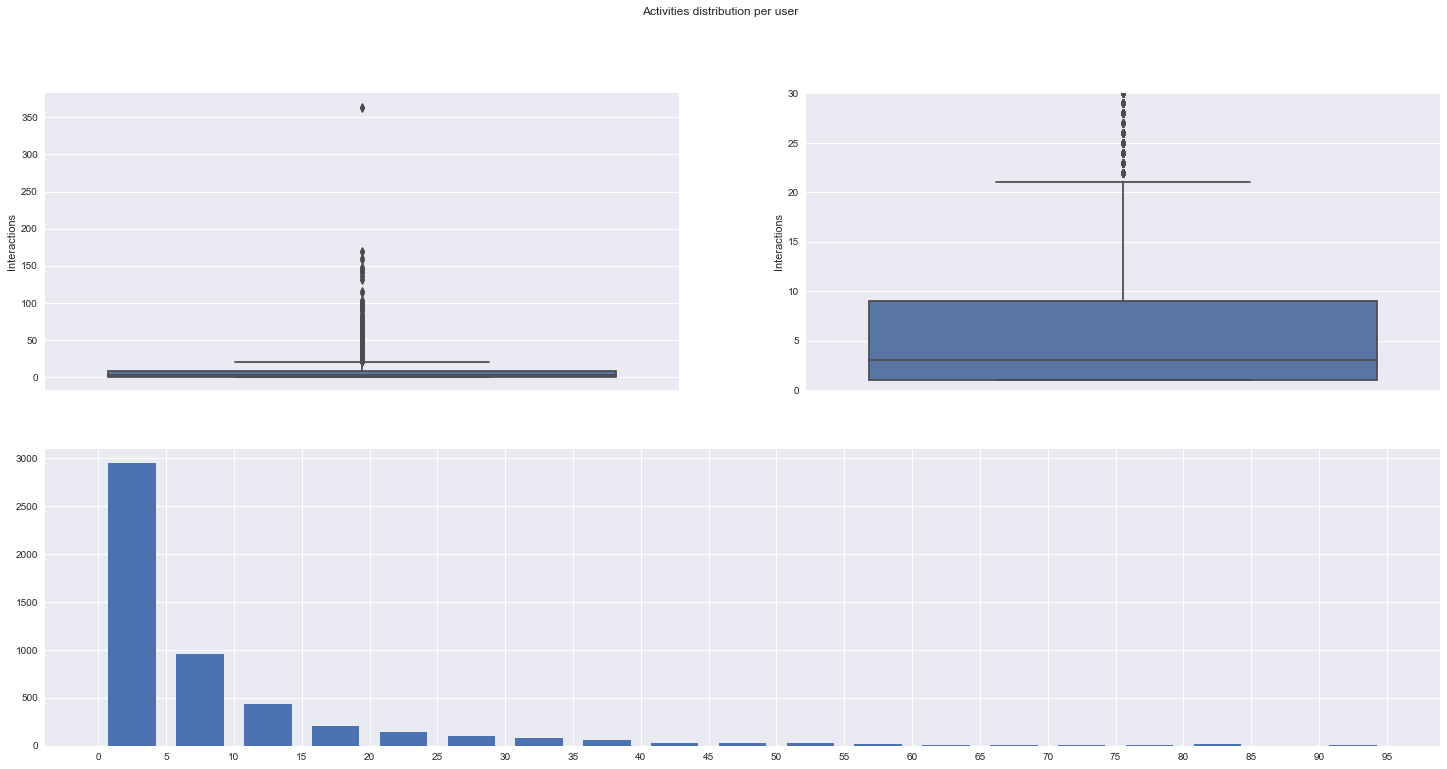

In [6]:
plt.figure(figsize=(25, 12))
plt.suptitle("Activities distribution per user")

plt.subplot(221)
sns.boxplot(y=interaction_per_user)
plt.ylabel('Interactions')

plt.subplot(222)
sns.boxplot(y=interaction_per_user)
plt.ylabel('Interactions')
plt.ylim(0, 30);

plt.subplot(212)
plt.hist(interaction_per_user, **hist_args)
plt.xticks(hist_args['bins']);

_Figure: boxplot of the activities in its full scale (top left) and an "enlargement" (top right).
<br>
The IQR is really small and the majority of the values is in a small interval, as shown in the histogram (bottom)_

### Most active users

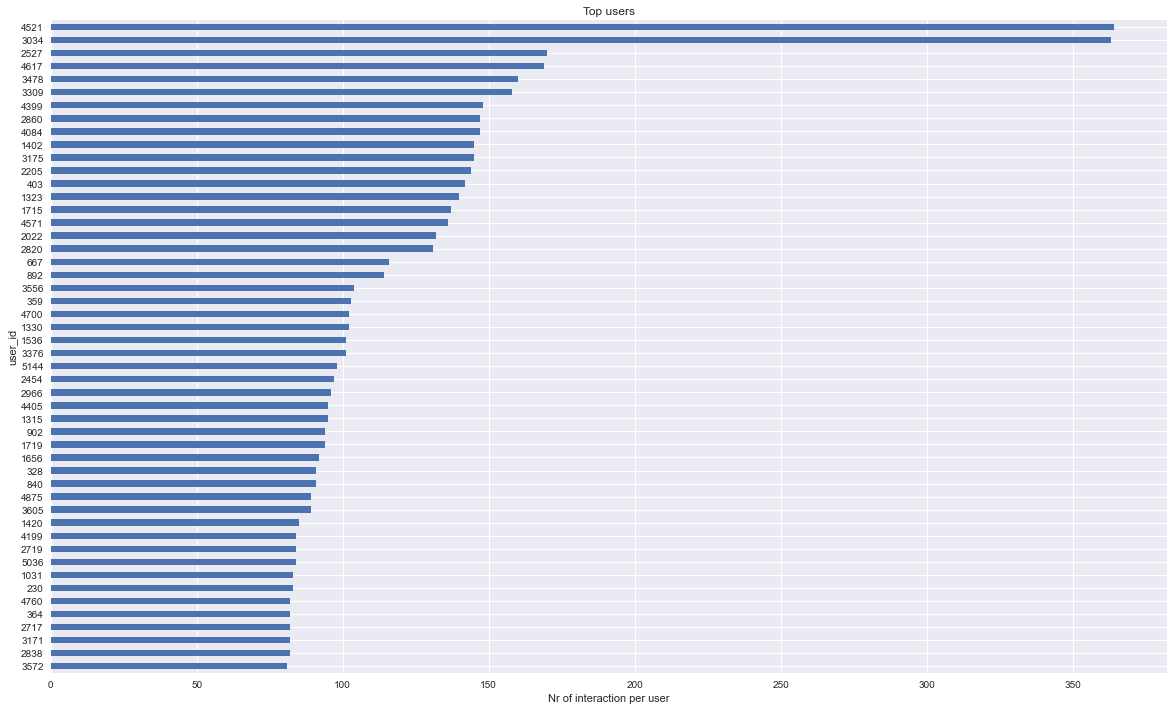

In [7]:
plt.figure(**bar_args)
interaction_per_user.sort_values(ascending=True).tail(50).plot.barh(ax=plt.gca())

plt.title("Top users")
plt.xlabel("Nr of interaction per user");

_Figure: the most active users have a lot more interactions than the majority of other users_

## Reading per user
More or less, the same happes for the number of article read by the users.

In [8]:
user_matrix = u.user_matrix
article_read_per_user = user_matrix.sum(axis=1)
describe(article_read_per_user)

count            5148
mean          6.54021
std           9.99068
min                 1
25%                 1
50%                 3
75%                 7
max               135
                     
IQR                 6
bottom_out          0
top_out            16
n_outliers        502
dtype: object

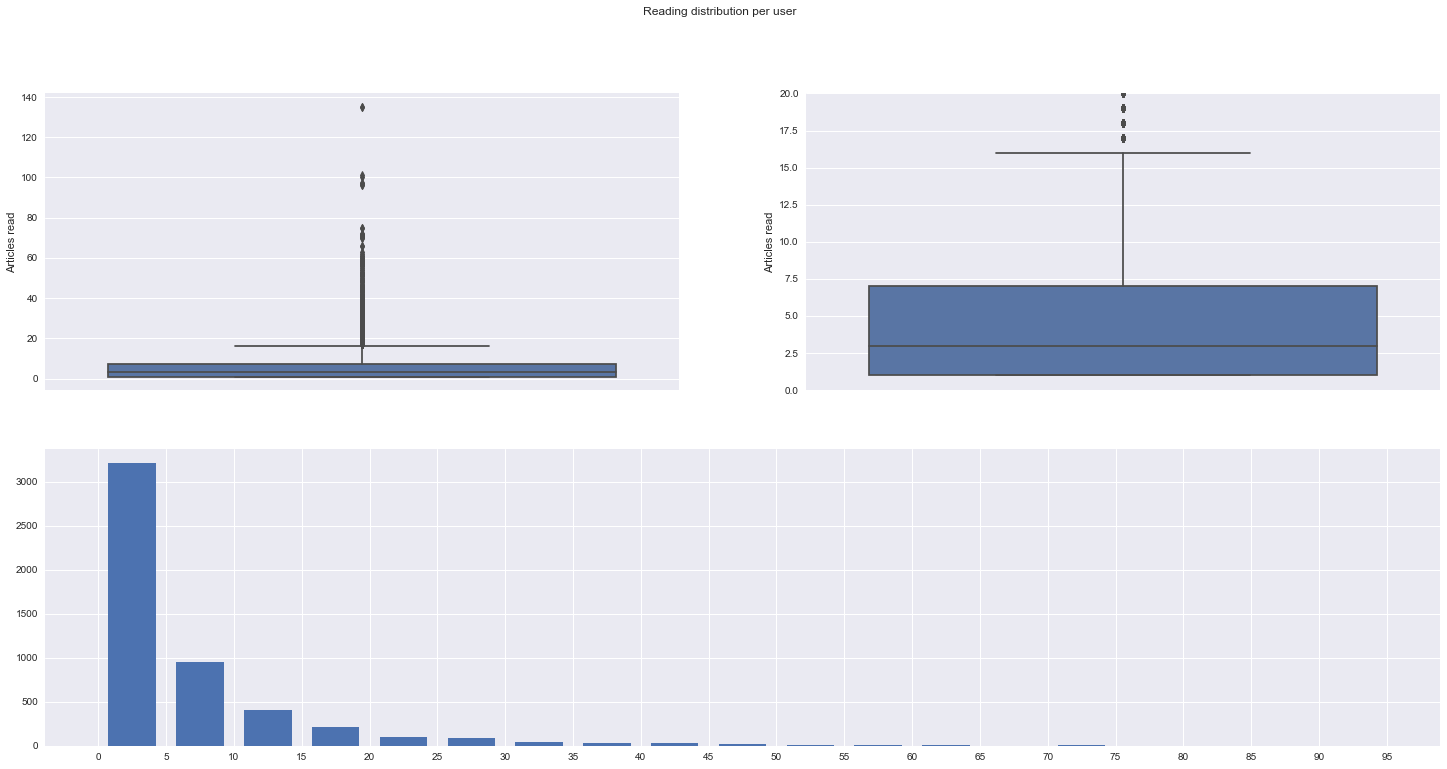

In [9]:
plt.figure(figsize=(25, 12))
plt.suptitle("Reading distribution per user")

plt.subplot(221)
sns.boxplot(y=article_read_per_user)
plt.ylabel('Articles read')

plt.subplot(222)
sns.boxplot(y=article_read_per_user)
plt.ylabel('Articles read')
plt.ylim(0, 20);

plt.subplot(212)
plt.hist(article_read_per_user, **hist_args);
plt.xticks(hist_args['bins']);

_Figure: boxplot of the readings in its full scale (top left) and an "enlargement" (top right).
<br>
The IQR is small and the majority of the values is in a small interval, as shown in the histogram (bottom)_

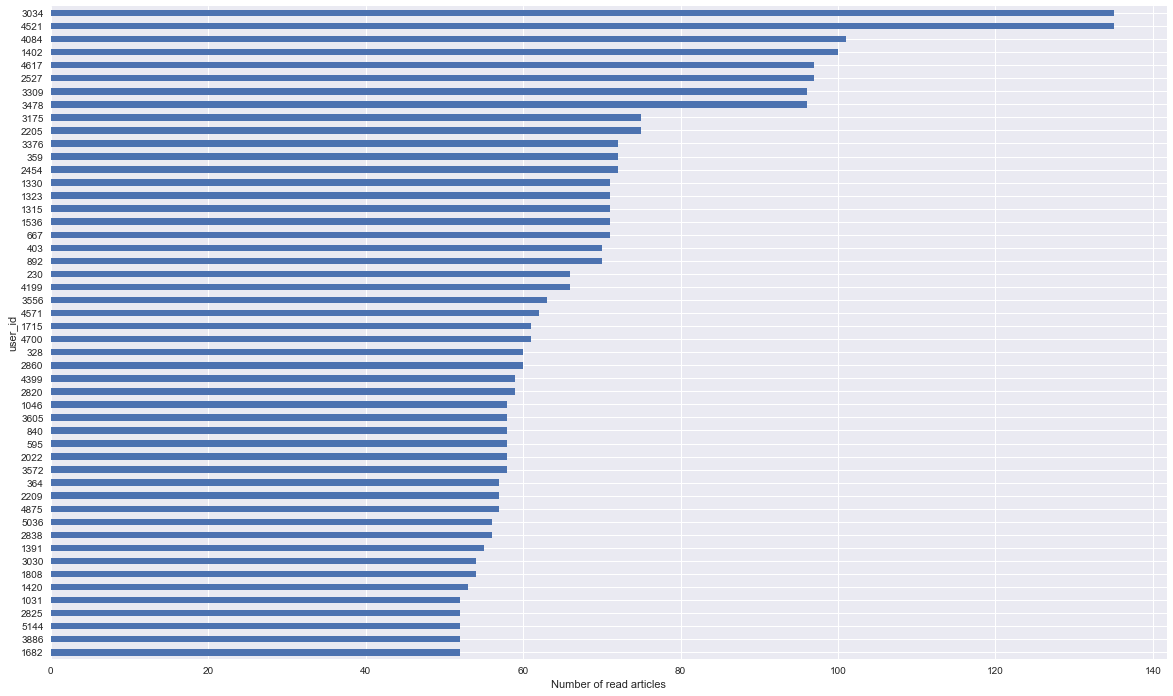

In [10]:
plt.figure(**bar_args)
article_read_per_user.sort_values(ascending=True).tail(50).plot.barh(ax=plt.gca())
plt.xlabel("Number of read articles");

_Figure: the most active users have a lot more article read than the majority of other users_

## Articles with most activities

In [11]:
activities_per_article = df.groupby('article_id').user_id.count()
describe(activities_per_article)

count             714
mean          64.3922
std           109.161
min                 1
25%                 8
50%                25
75%                69
max               937
                     
IQR                61
bottom_out          0
top_out         160.5
n_outliers         69
Name: user_id, dtype: object

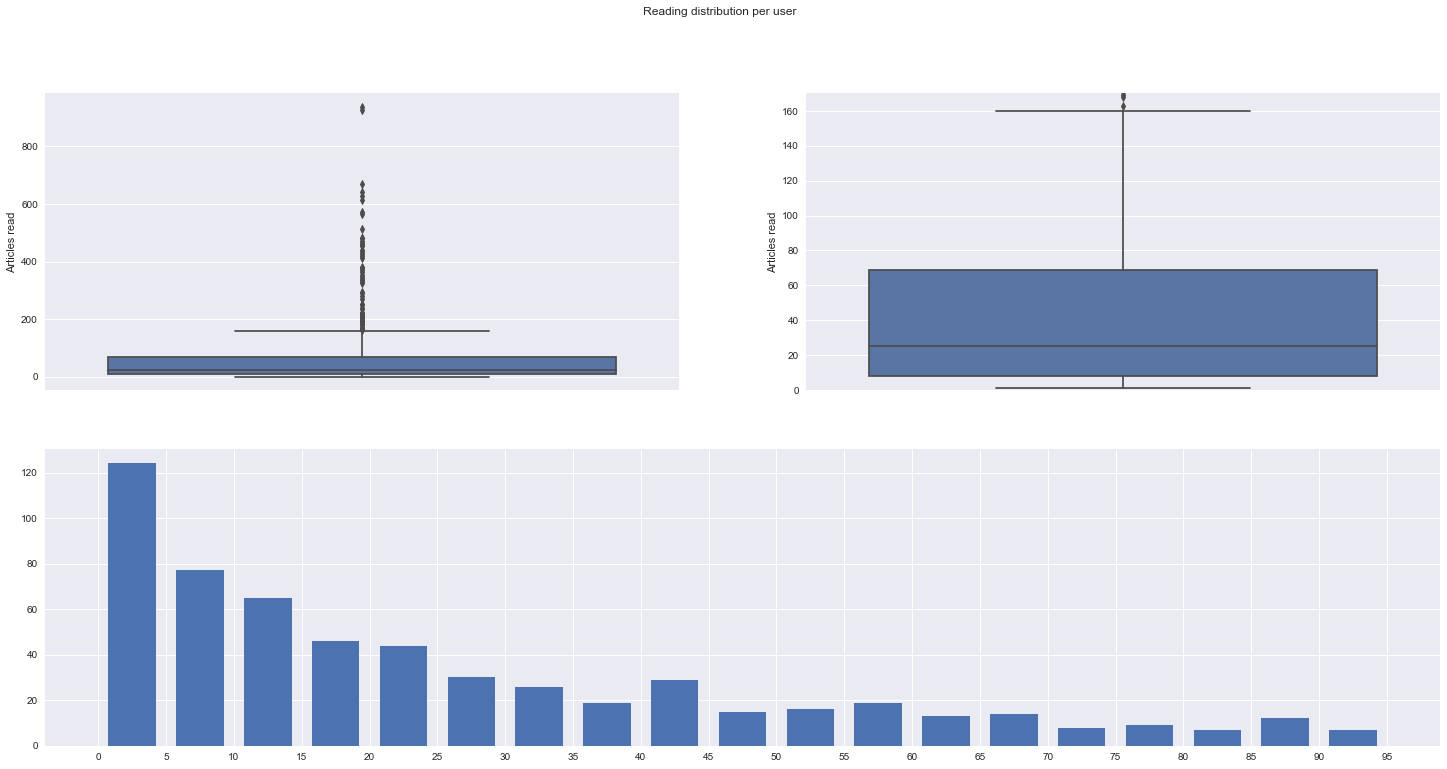

In [12]:
plt.figure(figsize=(25, 12))
plt.suptitle("Reading distribution per user")

plt.subplot(221)
sns.boxplot(y=activities_per_article)
plt.ylabel('Articles read')

plt.subplot(222)
sns.boxplot(y=activities_per_article)
plt.ylabel('Articles read')
plt.ylim(0, 170);

plt.subplot(212)
plt.hist(activities_per_article, **hist_args)
plt.xticks(hist_args['bins']);

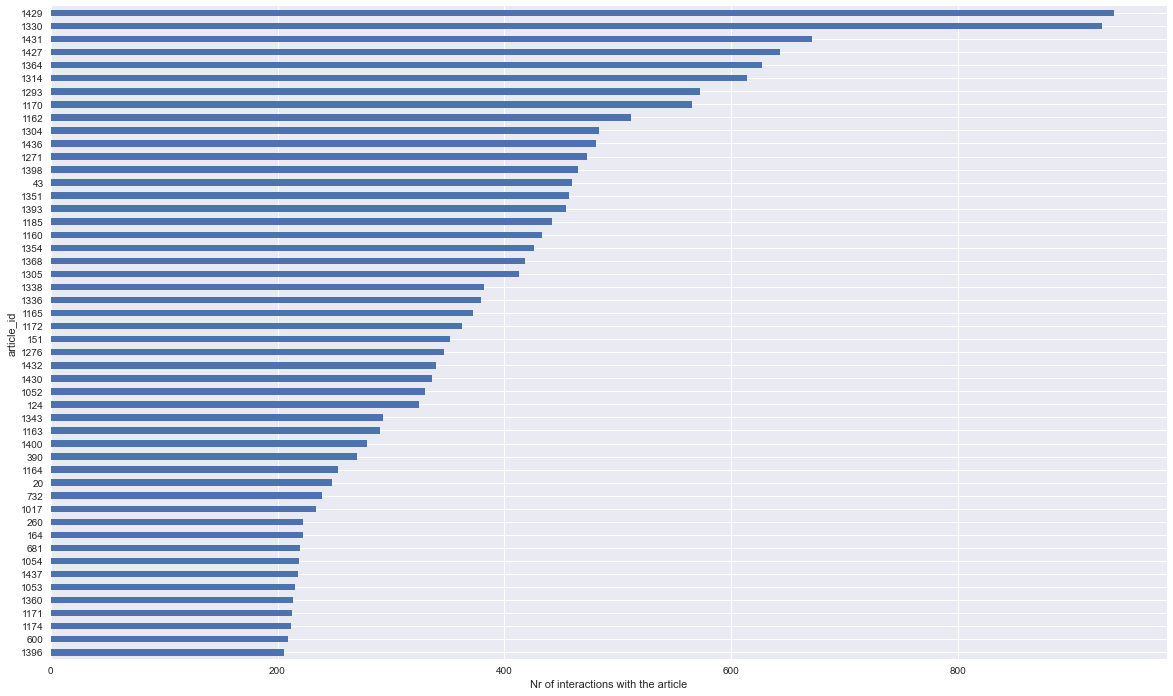

In [13]:
plt.figure(**bar_args)
activities_per_article.sort_values(ascending=True).tail(50).plot.barh(ax=plt.gca())
plt.xlabel("Nr of interactions with the article");

_Figure: boxplot of the activities for each article in its full scale (top left) and an "enlargement" (top right).
<br>
The IQR is small and the majority of the values is in a small interval, as shown in the histogram (bottom)_

## Popularity of each article
here is the number of unique users that have read the given article (at least once)

In [14]:
user_matrix = u.user_matrix
popularity_per_article = user_matrix.sum(axis=0)
describe(popularity_per_article)

count             714
mean          47.1555
std           65.4559
min                 1
25%                 7
50%              21.5
75%                59
max               467
                     
IQR                52
bottom_out          0
top_out           137
n_outliers         58
dtype: object

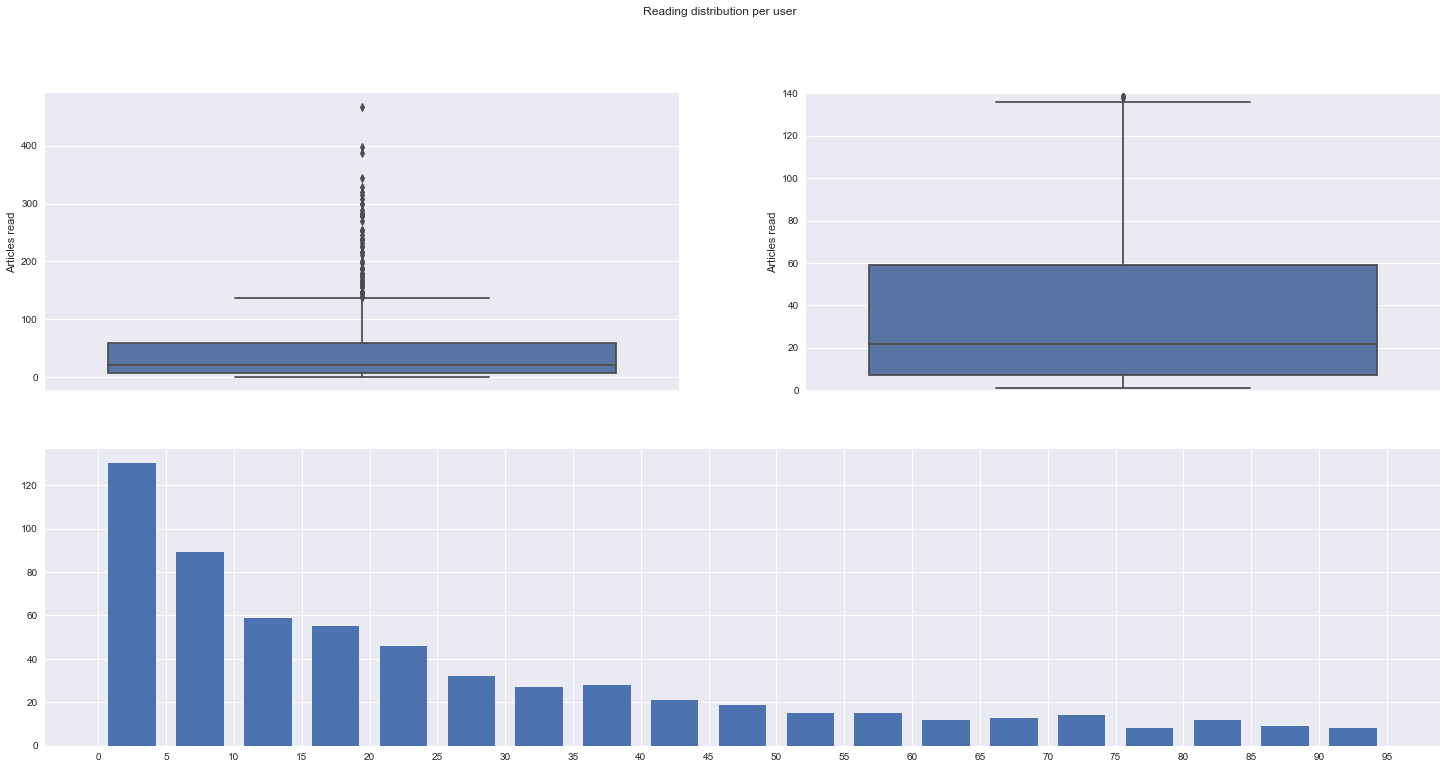

In [15]:
plt.figure(figsize=(25, 12))
plt.suptitle("Reading distribution per user")

plt.subplot(221)
sns.boxplot(y=popularity_per_article)
plt.ylabel('Articles read')

plt.subplot(222)
sns.boxplot(y=popularity_per_article)
plt.ylabel('Articles read')
plt.ylim(0, 140);

plt.subplot(212)
plt.hist(popularity_per_article, **hist_args)
plt.xticks(hist_args['bins']);

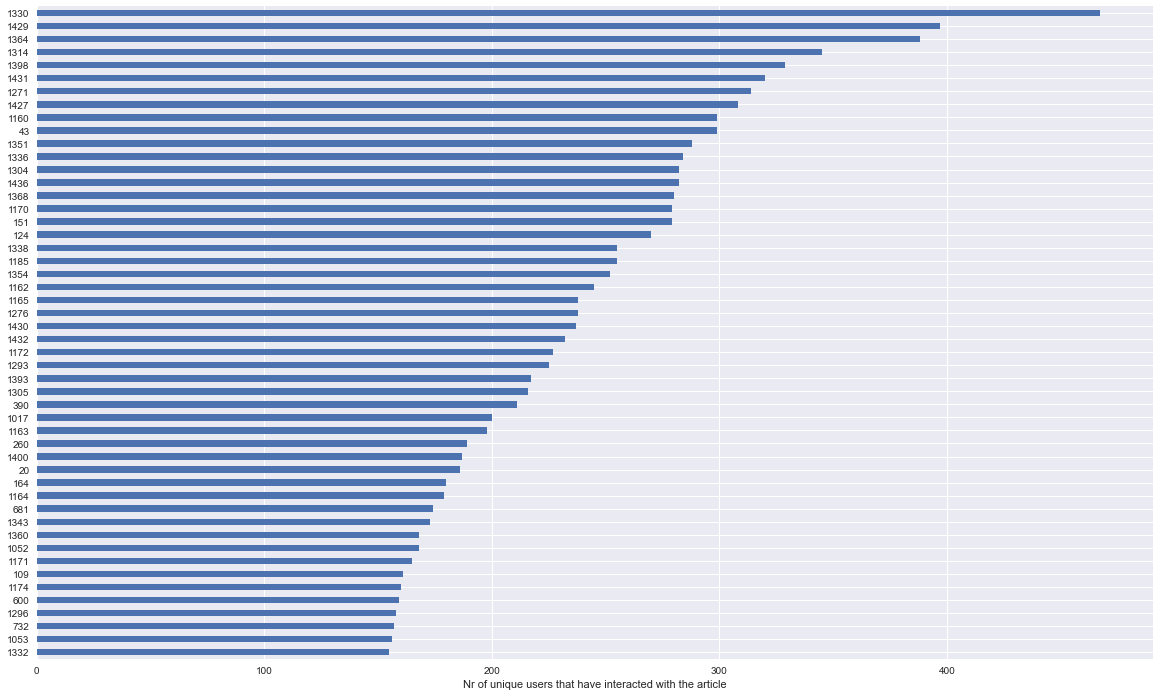

In [16]:
plt.figure(**bar_args)
popularity_per_article.sort_values(ascending=True).tail(50).plot.barh(ax=plt.gca())
plt.xlabel("Nr of unique users that have interacted with the article");

_Figure: the 50 articles with the most unique readers
<br>
The top articles will be the ones suggested for new users_

# II. Rank Based Recommendations
To get started in building recommendations, you will first find the most popular articles simply based on the most interactions.
<br>
Since there are no ratings for any of the articles, it is easy to assume the articles with the most interactions are the most popular.
<br>
These are then the articles we might recommend to new users (or anyone depending on what we know about them).

### Get top articles
To get the top articles run the method `get_top_articles` of the class `UserList`.
<br>
Set the arguments
* `unique_readers`
    * _True_ (default): articles are ranked based on the number of users that have read the article (* interactions from a user correspond to "score" 1)
    * _False_: articles are ranked based on the number of interactions (* interactions from a user correspond to "score" *)
* `titles`
    * _True_: returns the title of the articles
    * _False_ (default): returns the ids of the articles
<br>
These will be the articles suggested to new users (users for which we do not have enough information).

In [17]:
n_top = 10 # number of articles
top_articles_by_interactions = pd.DataFrame(data=(u.get_top_articles(unique_readers=False),
                                                 u.get_top_articles(unique_readers=False, titles=True)),
                                           index=['article_id', 'title']).T.set_index('article_id')

top_articles_by_unique_readers = pd.DataFrame(data=(u.get_top_articles(unique_readers=True), 
                                                   u.get_top_articles(unique_readers=True, titles=True)),
                                              index=['article_id', 'title']).T.set_index('article_id')
print("Top articles by interactions")
print("----------------------------")
print(top_articles_by_interactions.iloc[: n_top])
print('\n\n')
print("Top articles by unique readers")
print("----------------------------")
print(top_articles_by_unique_readers.iloc[: n_top])

Top articles by interactions
----------------------------
                                                        title
article_id                                                   
1429               use deep learning for image classification
1330              insights from new york car accident reports
1431                           visualize car data with brunel
1427        use xgboost, scikit-learn & ibm watson machine...
1364        predicting churn with the spss random tree alg...
1314             healthcare python streaming application demo
1293        finding optimal locations of new store using d...
1170                 apache spark lab, part 1: basic concepts
1162                  analyze energy consumption in buildings
1304        gosales transactions for logistic regression m...



Top articles by unique readers
----------------------------
                                                        title
article_id                                                   
1330       

# III. User-User Based Collaborative Filtering

In order to build better recommendations for the users of IBM's platform, we could look at users that are similar in terms of the items they have interacted with.
<br>
These items could then be recommended to the similar users.
<br>
This would be a step in the right direction towards more personal recommendations for the users.
<br>
You will implement this next.

### Get similar users
To get the users with similar test to the input user run the method `get_most_similar_user` of the class `UserList`.
<br>
The only argument of this function is the `user_id`.

In [18]:
# The top n_top for user id 1
u.get_most_similar_users(0)[ : n_top]

[228, 961, 1092, 2367, 227, 313, 3875, 3636, 1757, 1716]

In [19]:
# we can get the n_top most similar users for each user id in a DataFrame.
users = sorted(df.user_id.unique().tolist())
most_similar_for_all_user = list(map(lambda x: u.get_most_similar_users(x)[: n_top], progr(users)))
most_similar_for_each_user = pd.DataFrame(most_similar_for_all_user, index=users).T
most_similar_for_each_user

100%|#############################################################################################################################################################################################| 5148/5148 [00:24<00:00, 213.50it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,...,5136,5137,5138,5139,5140,5141,5142,5143,5144,5145,5146,5147
0,228,2182,3387,678,365,25,4689,616,4454,4470,5042,2229,...,726,3121,378,2981,628,4357,181,4459,2966,3909,4441,3566
1,961,3056,503,2658,1760,3790,3499,669,1629,1346,1502,3160,...,1476,904,2984,4441,5118,3344,905,4926,661,2322,3374,101
2,1092,1535,4930,782,3325,3661,2862,1317,1149,1242,1472,1693,...,4455,2583,2445,3374,4292,3457,2066,837,453,2607,573,108
3,2367,685,427,3115,3577,2977,3258,1675,14,2228,101,291,...,4283,4860,5054,573,1600,2775,2722,1637,1775,483,626,318
4,227,737,104,424,4239,1394,1247,3425,448,1066,108,1629,...,2777,2916,4973,626,3929,1481,3864,1886,2353,3449,1734,4129
5,313,1261,5030,4187,4412,3005,3450,4262,167,3910,318,5080,...,1037,2295,288,1734,3371,2042,3896,2766,4154,4162,2224,4919
6,3875,3560,447,3795,4773,3117,4540,54,2713,1498,4129,2607,...,1618,4721,2116,2224,2993,130,630,3043,2343,452,2386,678
7,3636,4013,1643,4799,3010,1104,3596,2187,3628,575,4919,8,...,3619,91,5121,2386,3336,707,1436,4271,2985,1134,2692,2658
8,1757,1647,1807,3566,2428,1130,5041,2480,1698,2349,4886,14,...,3443,549,5042,2692,707,924,2903,600,2050,3839,3362,3115
9,1716,4466,2017,4373,4711,2077,812,3063,2004,2080,2456,4454,...,1105,1197,10,3362,970,1922,4935,3148,2503,407,3370,177


_Table: Each column has as name a user id and its elements are the ids of the most similar other users, sorted from most to less similar_

### Get recommendation
To get the recommendations for a given user run the method `get_user_rewcommendations` of the class `UserList`.
<br>
The main argument of this function is the `user_id`.
<br>
Other arguments are
* `titles`
    * _True_: returns the title of the articles
    * _False_ (default): returns the ids of the articles
* `n_max` (default = 10): maximum number of recommendations to return

In [20]:
print(u.get_user_recommendations(0))
print(u.get_user_recommendations(0, titles=True))

[681, 809, 892, 1053, 1160, 1170, 1296, 1332, 1418, 1429]
['real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)', 'use the machine learning library', 'breaking the 80/20 rule: how data catalogs transform data scientists’ productivity', 'access mysql with python', 'analyze accident reports on amazon emr spark', 'apache spark lab, part 1: basic concepts', 'fortune 100 companies', 'intents & examples for ibm watson conversation', 'united states demographic measures: zip code tabulation areas (zctas)', 'use deep learning for image classification']


The script `get_user_recommendations` will iterate on every user, from the most to the least similar and return the articles they have read (that user 0 did not yet read).
<br>
The following set of instructions shows the articles read by the top 10 similar users to user 0.

In [24]:
list(map(lambda x: u.get_articles_read_by_user_id(x), most_similar_for_each_user[0]))

[[892],
 [892],
 [892],
 [681, 892, 1160, 1418],
 [681, 809, 892, 1160, 1418],
 [415, 892, 1053, 1170, 1296, 1332, 1429],
 [65, 108, 110, 151, 202, 241, 260, 369, 542, 681, 892, 1014, 1017, 1436],
 [65, 108, 110, 151, 202, 241, 260, 369, 542, 681, 892, 1014, 1017, 1436],
 [12,
  43,
  57,
  108,
  162,
  241,
  260,
  311,
  329,
  462,
  857,
  891,
  892,
  939,
  957,
  1183,
  1271,
  1304],
 [12,
  43,
  57,
  108,
  162,
  241,
  260,
  311,
  329,
  462,
  645,
  857,
  891,
  892,
  939,
  957,
  1183,
  1271,
  1304]]

In [27]:
# we can get the recommended articles for each user id in a DataFrame.
recommendations_for_all_users = list(map(lambda x: u.get_user_recommendations(x), progr(users)))
recommendations_for_each_user = pd.DataFrame(recommendations_for_all_users, index=users).T
recommendations_for_each_user

100%|##############################################################################################################################################################################################| 5148/5148 [02:09<00:00, 39.89it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,...,5136,5137,5138,5139,5140,5141,5142,5143,5144,5145,5146,5147
0,681,65,43,288,30,76,268,234,32,122,68,194,...,57,120,53,0,34,193,12,87,8,194,362,68
1,809,117,76,310,115,329,486,809,559,241,240,314,...,138,263,151,33,101,224,98,224,12,730,1282,221
2,892,390,268,465,151,350,678,865,1170,263,426,1170,...,153,607,240,193,108,1160,113,250,131,833,1314,288
3,1053,593,369,809,448,390,930,1271,1171,911,473,1176,...,213,858,732,254,359,1166,145,390,136,981,1330,310
4,1160,626,593,965,730,833,993,1299,1172,1162,542,1282,...,645,1016,809,390,460,1293,616,641,260,1050,1364,379
5,1170,634,647,1172,795,1138,1059,1360,1282,1186,593,1314,...,667,1054,969,868,1160,1314,617,675,268,1157,1391,809
6,1296,1025,744,1330,962,1174,1293,1404,1304,1304,695,1343,...,686,1055,1056,919,1165,1336,1025,1181,645,1351,1398,1330
7,1332,1183,951,1420,1278,1185,1360,1409,1343,1305,764,1351,...,1330,1056,1320,1078,1293,1429,1170,1185,766,1354,1416,1364
8,1418,1394,1024,1424,1305,1271,1427,1418,1364,1351,855,1354,...,1351,1165,1343,1282,1354,1431,1337,1431,1162,1368,1432,1420
9,1429,1430,1025,1436,1343,1330,1430,1430,1398,1386,1050,1398,...,1363,1166,1430,1398,1429,1432,1436,1435,1416,1429,1436,1424


_Table: Each column has as name a user id and its elements are the ids of the recommended articles_